In [1]:
# from google.colab import drive
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import torchvision
from PIL import Image



from torch.utils.data import Dataset, DataLoader, BatchSampler, random_split
from torchvision import transforms
from torch.utils.data import Subset
from PIL import Image

In [2]:
# # Mount Google Drive
# drive.mount('/content/drive')
print(torch.__version__)

2.0.0+cu118


In [55]:
# Create Dataset class for multilabel classification
class MultiClassImageDataset(Dataset):
    def __init__(self, ann_df, super_map_df, sub_map_df, img_dir, transform=None):
        self.ann_df = ann_df
        self.super_map_df = super_map_df
        self.sub_map_df = sub_map_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.ann_df)
    
    def upscale_image(self, image):
        # Upscale the image using bicubic interpolation
        width, height = image.size
        upscaled_image = image.resize((128,128), Image.BICUBIC)
        return upscaled_image

    def __getitem__(self, idx):
        img_name = self.ann_df['image'][idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Upscale the image
        image = self.upscale_image(image)

        super_idx = self.ann_df['superclass_index'][idx]
        super_label = self.super_map_df['class'][super_idx]

        sub_idx = self.ann_df['subclass_index'][idx]
        sub_label = self.sub_map_df['class'][sub_idx]

        if self.transform:
            image = self.transform(image)

        return image, super_idx, super_label, sub_idx, sub_label

class MultiClassImageTestDataset(Dataset):
    def __init__(self, super_map_df, sub_map_df, img_dir, transform=None):
        self.super_map_df = super_map_df
        self.sub_map_df = sub_map_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self): # Count files in img_dir
        return len([fname for fname in os.listdir(self.img_dir)])

    def __getitem__(self, idx):
        img_name = str(idx) + '.jpg'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, img_name

In [56]:
# def random_split(dataset, lengths):
#     r"""
#     Randomly split a dataset into non-overlapping new datasets of given lengths.

#     If a list of fractions that sum up to 1 is given,
#     the lengths will be computed automatically as
#     floor(frac * len(dataset)) for each fraction provided.

#     After computing the lengths, if there are any remainders, 1 count will be
#     distributed in round-robin fashion to the lengths
#     until there are no remainders left.

#     Optionally fix the generator for reproducible results, e.g.:

#     >>> random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
#     >>> random_split(range(30), [0.3, 0.3, 0.4], generator=torch.Generator(
#     ...   ).manual_seed(42))

#     Args:
#         dataset (Dataset): Dataset to be split
#         lengths (sequence): lengths or fractions of splits to be produced
#         generator (Generator): Generator used for the random permutation.
#     """
#     if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
#         subset_lengths: List[int] = []
#         for i, frac in enumerate(lengths):
#             if frac < 0 or frac > 1:
#                 raise ValueError(f"Fraction at index {i} is not between 0 and 1")
#             n_items_in_split = int(
#                 math.floor(len(dataset) * frac)  # type: ignore[arg-type]
#             )
#             subset_lengths.append(n_items_in_split)
#         remainder = len(dataset) - sum(subset_lengths)  # type: ignore[arg-type]
#         # add 1 to all the lengths in round-robin fashion until the remainder is 0
#         for i in range(remainder):
#             idx_to_add_at = i % len(subset_lengths)
#             subset_lengths[idx_to_add_at] += 1
#         lengths = subset_lengths
#         for i, length in enumerate(lengths):
#             if length == 0:
#                 warnings.warn(f"Length of split at index {i} is 0. "
#                               f"This might result in an empty dataset.")

#     # Cannot verify that dataset is Sized
#     if sum(lengths) != len(dataset):    # type: ignore[arg-type]
#         raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

#     indices = torch.randperm(sum(lengths)).tolist()
#     offsets = [0] + list(itertools.accumulate(lengths))
#     return [Subset(dataset, indices[offset : offset + length]) for offset, length in zip(offsets, lengths)]

In [57]:
train_ann_df = pd.read_csv('train_data_new.csv')
super_map_df = pd.read_csv('superclass_mapping.csv')
sub_map_df = pd.read_csv('subclass_mapping.csv')

train_img_dir = 'train_shuffle_transformed'
test_img_dir = 'test_shuffle'

image_preprocessing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0), std=(1)),
])

# Create train and val split
train_dataset = MultiClassImageDataset(train_ann_df, super_map_df, sub_map_df, train_img_dir, transform=image_preprocessing)
print(len(train_dataset))
train_dataset, val_dataset = random_split(train_dataset, [0.9, 0.1])

# Create test dataset
test_dataset = MultiClassImageTestDataset(super_map_df, sub_map_df, test_img_dir, transform=image_preprocessing)

# Create dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=1,
                         shuffle=False)

6858


In [13]:
sub = []
sup = []
inp = []
for i, data in enumerate(train_dataset):
            inputs, super_labels, sub_labels = data[0], data[1], data[3]
            sub.append(sub_labels)
            sup.append(super_labels)
            inp.append(inputs)
    

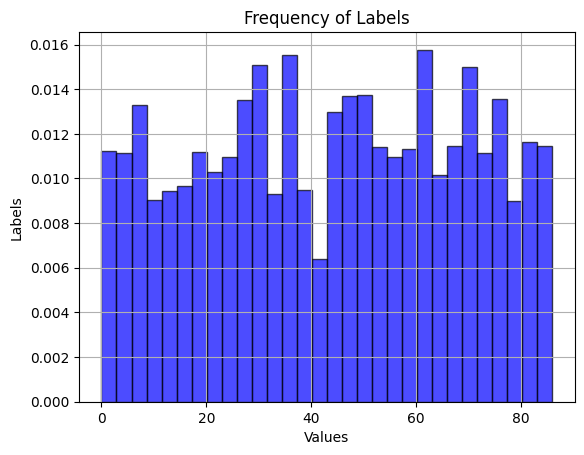

In [14]:
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(sub, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Frequency of Labels')
plt.xlabel('Values')
plt.ylabel('Labels')
plt.grid(True)
plt.show()

In [51]:
# Simple CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(
                        nn.Conv2d(3, 32, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32, 32, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32, 32, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(2, 2)
                      )

        self.block2 = nn.Sequential(
                        nn.Conv2d(32, 64, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64, 64, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64, 64, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2, 2)
                      )

        self.block3 = nn.Sequential(
                        nn.Conv2d(64, 128, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128, 128, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128, 128, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2, 2)
                      )

        self.fc1 = nn.Linear(4*4*128, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3a = nn.Linear(128, 4)
        self.fc3b = nn.Linear(128, 88)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        super_out = self.fc3a(x)
        sub_out = self.fc3b(x)
        return super_out, sub_out

class Trainer():
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, test_loader=None, device='cuda'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device

    def train_epoch(self):
        running_loss = 0.0
        device = self.device
        for i, data in enumerate(self.train_loader):
            inputs, super_labels, sub_labels = data[0].to(device), data[1].to(device), data[3].to(device)

            self.optimizer.zero_grad()
            super_outputs, sub_outputs = self.model(inputs)
            loss = self.criterion(super_outputs, super_labels) + self.criterion(sub_outputs, sub_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Training loss: {running_loss/i:.3f}')

    def validate_epoch(self):
        super_correct = 0
        sub_correct = 0
        total = 0
        running_loss = 0.0
        device = self.device
        with torch.no_grad():
            for i, data in enumerate(self.val_loader):
                inputs, super_labels, sub_labels = data[0].to(device), data[1].to(device), data[3].to(device)

                super_outputs, sub_outputs = self.model(inputs)
                loss = self.criterion(super_outputs, super_labels) + self.criterion(sub_outputs, sub_labels)
                _, super_predicted = torch.max(super_outputs.data, 1)
                _, sub_predicted = torch.max(sub_outputs.data, 1)

                total += super_labels.size(0)
                super_correct += (super_predicted == super_labels).sum().item()
                sub_correct += (sub_predicted == sub_labels).sum().item()
                running_loss += loss.item()

        print(f'Validation loss: {running_loss/i:.3f}')
        print(f'Validation superclass acc: {100 * super_correct / total:.2f} %')
        print(f'Validation subclass acc: {100 * sub_correct / total:.2f} %')

    def test(self, save_to_csv=False, return_predictions=False):
        if not self.test_loader:
            raise NotImplementedError('test_loader not specified')

        # Evaluate on test set, in this simple demo no special care is taken for novel/unseen classes
        test_predictions = {'image': [], 'superclass_index': [], 'subclass_index': []}
        with torch.no_grad():
            for i, data in enumerate(self.test_loader):
                inputs, img_name = data[0].to(device), data[1]

                super_outputs, sub_outputs = self.model(inputs)
                _, super_predicted = torch.max(super_outputs.data, 1)
                _, sub_predicted = torch.max(sub_outputs.data, 1)

                test_predictions['image'].append(img_name[0])
                test_predictions['superclass_index'].append(super_predicted.item())
                test_predictions['subclass_index'].append(sub_predicted.item())

        test_predictions = pd.DataFrame(data=test_predictions)

        if save_to_csv:
            test_predictions.to_csv('example_test_predictions.csv', index=False)

        if return_predictions:
            return test_predictions

In [7]:
# Init model and trainer
device = 'cuda'
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, test_loader)

In [8]:
# Training loop
for epoch in range(20):
    print(f'Epoch {epoch+1}')
    trainer.train_epoch()
    trainer.validate_epoch()
    print('')

print('Finished Training')

Epoch 1
Training loss: 4.134
Validation loss: 3.705
Validation superclass acc: 84.34 %
Validation subclass acc: 15.98 %

Epoch 2
Training loss: 3.179
Validation loss: 3.214
Validation superclass acc: 86.23 %
Validation subclass acc: 25.95 %

Epoch 3
Training loss: 2.594
Validation loss: 2.889
Validation superclass acc: 88.45 %
Validation subclass acc: 32.44 %

Epoch 4
Training loss: 2.242
Validation loss: 2.904
Validation superclass acc: 85.44 %
Validation subclass acc: 34.81 %

Epoch 5
Training loss: 1.903
Validation loss: 2.564
Validation superclass acc: 90.66 %
Validation subclass acc: 37.97 %

Epoch 6
Training loss: 1.592
Validation loss: 2.390
Validation superclass acc: 92.56 %
Validation subclass acc: 42.72 %

Epoch 7
Training loss: 1.321
Validation loss: 2.527
Validation superclass acc: 92.56 %
Validation subclass acc: 41.93 %

Epoch 8
Training loss: 1.067
Validation loss: 2.512
Validation superclass acc: 93.20 %
Validation subclass acc: 45.41 %

Epoch 9
Training loss: 0.857
Val

In [9]:
trainer.test(save_to_csv=True, return_predictions=True)

'''
This simple baseline scores the following test accuracy

Superclass Accuracy
Overall: 43.83 %
Seen: 61.11 %
Unseen: 0.00 %

Subclass Accuracy
Overall: 2.03 %
Seen: 9.56 %
Unseen: 0.00 %
'''

'\nThis simple baseline scores the following test accuracy\n\nSuperclass Accuracy\nOverall: 43.83 %\nSeen: 61.11 %\nUnseen: 0.00 %\n\nSubclass Accuracy\nOverall: 2.03 %\nSeen: 9.56 %\nUnseen: 0.00 %\n'

In [68]:
# Simple CNN
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
                        nn.Conv2d(3, 32, 3),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32, 32, 3),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32, 64, 3),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
                        nn.Conv2d(64, 64, 3),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64, 128, 3),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128, 128, 3),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
             nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),
                        nn.Conv2d(128, 256, 3),
                        nn.ReLU(),
                        nn.BatchNorm2d(256),
                        nn.Conv2d(256, 256, 3),
                        nn.ReLU(),
                        nn.BatchNorm2d(256),
                        nn.Conv2d(256, 256, 3),
                        nn.ReLU(),
                        nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
                        nn.Conv2d(256, 256, 3),
                        nn.ReLU(),
                        nn.BatchNorm2d(256),
                        nn.Conv2d(256, 256, 3),
                        nn.ReLU(),
                        nn.BatchNorm2d(256),
                        nn.Conv2d(256, 512, 3),
                        nn.ReLU(),
                        nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
         
                      )
        self.fc1 = nn.Linear(2048, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3a = nn.Linear(128, 4)
        self.fc3b = nn.Linear(128, 88)


    def forward(self, x):
        x = self.block_1(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        super_out = self.fc3a(x)
        sub_out = self.fc3b(x)
        return super_out, sub_out

class Trainer():
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, test_loader=None, device='cuda'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device

    def train_epoch(self):
        running_loss = 0.0
        device = self.device
        for i, data in enumerate(self.train_loader):
            inputs, super_labels, sub_labels = data[0].to(device), data[1].to(device), data[3].to(device)

            self.optimizer.zero_grad()
            super_outputs, sub_outputs = self.model(inputs)
            loss = self.criterion(super_outputs, super_labels) + self.criterion(sub_outputs, sub_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Training loss: {running_loss/i:.3f}')

    def validate_epoch(self):
        super_correct = 0
        sub_correct = 0
        total = 0
        running_loss = 0.0
        device = self.device
        with torch.no_grad():
            for i, data in enumerate(self.val_loader):
                inputs, super_labels, sub_labels = data[0].to(device), data[1].to(device), data[3].to(device)

                super_outputs, sub_outputs = self.model(inputs)
                loss = self.criterion(super_outputs, super_labels) + self.criterion(sub_outputs, sub_labels)
                _, super_predicted = torch.max(super_outputs.data, 1)
                _, sub_predicted = torch.max(sub_outputs.data, 1)

                total += super_labels.size(0)
                super_correct += (super_predicted == super_labels).sum().item()
                sub_correct += (sub_predicted == sub_labels).sum().item()
                running_loss += loss.item()

        print(f'Validation loss: {running_loss/i:.3f}')
        print(f'Validation superclass acc: {100 * super_correct / total:.2f} %')
        print(f'Validation subclass acc: {100 * sub_correct / total:.2f} %')

    def test(self, save_to_csv=False, return_predictions=False):
        if not self.test_loader:
            raise NotImplementedError('test_loader not specified')

        # Evaluate on test set, in this simple demo no special care is taken for novel/unseen classes
        test_predictions = {'image': [], 'superclass_index': [], 'subclass_index': []}
        with torch.no_grad():
            for i, data in enumerate(self.test_loader):
                inputs, img_name = data[0].to(device), data[1]

                super_outputs, sub_outputs = self.model(inputs)
                _, super_predicted = torch.max(super_outputs.data, 1)
                _, sub_predicted = torch.max(sub_outputs.data, 1)

                test_predictions['image'].append(img_name[0])
                test_predictions['superclass_index'].append(super_predicted.item())
                test_predictions['subclass_index'].append(sub_predicted.item())

        test_predictions = pd.DataFrame(data=test_predictions)

        if save_to_csv:
            test_predictions.to_csv('example_test_predictions.csv', index=False)

        if return_predictions:
            return test_predictions

In [69]:
torch.cuda.is_available()

True

In [70]:
# inputs = []
# super_labels = []
# sub_labels = []
# for i, data in enumerate(val_dataset):
#                 inp, sup, sub = data[0], data[1], data[3]
#                 inputs.append(str(i)+'.jpg')
#                 super_labels.append(sup)
#                 sub_labels.append(sub)
# columns_1 = ['Index', 'Target']


# # Create DataFrame
# df_1 = pd.DataFrame(list(zip(inputs, super_labels)), columns=columns_1)

# # Create DataFrame
# df_2 = pd.DataFrame(list(zip(inputs, sub_labels)), columns=columns_1)

# df_1.to_csv('val_super.csv', index=False)
# df_2.to_csv('val_sub.csv', index=False)

In [71]:
# Init model and trainer
device = 'cuda'
model = AutoEncoder().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, test_loader)

In [72]:
# Training loop
for epoch in range(50):
    print(f'Epoch {epoch+1}')
    trainer.train_epoch()
    trainer.validate_epoch()
    print('')

print('Finished Training')

Epoch 1
Training loss: 5.052
Validation loss: 4.832
Validation superclass acc: 65.99 %
Validation subclass acc: 5.69 %

Epoch 2


KeyboardInterrupt: 

In [37]:
trainer.test(save_to_csv=True, return_predictions=True)

'''
This simple baseline scores the following test accuracy

Superclass Accuracy
Overall: 43.83 %
Seen: 61.11 %
Unseen: 0.00 %

Subclass Accuracy
Overall: 2.03 %
Seen: 9.56 %
Unseen: 0.00 %
'''

RuntimeError: a Tensor with 8 elements cannot be converted to Scalar

In [ ]:
# Read the CSV file into a DataFrame
file_path = 'example_test_predictions.csv'  # Replace with the actual file path
df = pd.read_csv(file_path)

# Display the original DataFrame
print("Original DataFrame:")
print(df)

# Select two columns
selected_columns = df[['image', 'subclass_index']]

# Rename one of the columns
selected_columns = selected_columns.rename(columns={'image': 'ID'})
selected_columns = selected_columns.rename(columns={'subclass_index': 'Target'})

# Save the modified DataFrame to a new CSV file
output_file_path = 'sub_test.csv'  # Replace with the desired output file path
selected_columns.to_csv(output_file_path, index=False)

# Select two columns
selected_column = df[['image', 'superclass_index']]

# Rename one of the columns
selected_column = selected_column.rename(columns={'image': 'ID'})
selected_column = selected_column.rename(columns={'superclass_index': 'Target'})
print(selected_columns)

# Save the modified DataFrame to a new CSV file
output_file_path = 'super_test.csv'  # Replace with the desired output file path
selected_column.to_csv(output_file_path, index=False)

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df_real = pd.read_csv('val_sub.csv')
df_predicted = pd.read_csv('sub_test.csv')
print(len(df_real), len(df_predicted))

# Create confusion matrix
conf_matrix = confusion_matrix(df_real['Target'], df_predicted['Target'])

# Display confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

685 12377


ValueError: Found input variables with inconsistent numbers of samples: [685, 12377]

In [61]:
self.encoder = nn.Sequential(
                        nn.Conv2d(3, 32, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32, 32, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(32, 64, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64, 64, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(64, 128, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128, 128, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                      )

        self.decoder = nn.Sequential(
                        nn.Conv2d(128, 128, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128, 64, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64, 64, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Upsample(2),
                        nn.Conv2d(64, 32, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32, 32, 3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Upsample(2)
                      )


        self.fc1 = nn.Linear(4*4*8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3a = nn.Linear(128, 4)
        self.fc3b = nn.Linear(128, 88)

IndentationError: unexpected indent (1345727966.py, line 24)

In [ ]:
# Simple CNN
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        ### Convolutional section
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding='same'),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, padding='same'),
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, padding='same'),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding='same'),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, padding='same'),
            nn.ReLU(True),
            nn.BatchNorm2d(128),
            nn.Flatten(start_dim=1),
            nn.Linear(4 * 4 * 8192, 256),
            nn.ReLU(True),
            nn.Linear(256, 128)
        )



        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 3 * 3 * 128),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(128, 3, 3)),
            nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 3,stride=2, output_padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 8, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(8, 3, 3, stride=2, output_padding=0)
        )


        self.fc1 = nn.Linear(48387, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3a = nn.Linear(128, 4)
        self.fc3b = nn.Linear(128, 88)

    def forward(self, x):
        x = self.encoder(x)
        # print(x.shape)
        x = self.decoder(x)
        # print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(x.shape)

        x = F.relu(self.fc1(x))
        # print(x.shape)
        x = F.relu(self.fc2(x))
        super_out = self.fc3a(x)
        sub_out = self.fc3b(x)
        return super_out, sub_out

class Trainer():
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, test_loader=None, device='cuda'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device

    def train_epoch(self):
        running_loss = 0.0
        device = self.device
        for i, data in enumerate(self.train_loader):
            inputs, super_labels, sub_labels = data[0], data[1], data[3]

            self.optimizer.zero_grad()
            super_outputs, sub_outputs = self.model(inputs)
            loss = self.criterion(super_outputs, super_labels) + self.criterion(sub_outputs, sub_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Training loss: {running_loss/i:.3f}')

    def validate_epoch(self):
        super_correct = 0
        sub_correct = 0
        total = 0
        running_loss = 0.0
        device = self.device
        with torch.no_grad():
            for i, data in enumerate(self.val_loader):
                inputs, super_labels, sub_labels = data[0], data[1], data[3]

                super_outputs, sub_outputs = self.model(inputs)
                loss = self.criterion(super_outputs, super_labels) + self.criterion(sub_outputs, sub_labels)
                _, super_predicted = torch.max(super_outputs.data, 1)
                _, sub_predicted = torch.max(sub_outputs.data, 1)

                total += super_labels.size(0)
                super_correct += (super_predicted == super_labels).sum().item()
                sub_correct += (sub_predicted == sub_labels).sum().item()
                running_loss += loss.item()

        print(f'Validation loss: {running_loss/i:.3f}')
        print(f'Validation superclass acc: {100 * super_correct / total:.2f} %')
        print(f'Validation subclass acc: {100 * sub_correct / total:.2f} %')

    def test(self, save_to_csv=False, return_predictions=False):
        if not self.test_loader:
            raise NotImplementedError('test_loader not specified')

        # Evaluate on test set, in this simple demo no special care is taken for novel/unseen classes
        test_predictions = {'image': [], 'superclass_index': [], 'subclass_index': []}
        with torch.no_grad():
            for i, data in enumerate(self.test_loader):
                inputs, img_name = data[0], data[1]

                super_outputs, sub_outputs = self.model(inputs)
                _, super_predicted = torch.max(super_outputs.data, 1)
                _, sub_predicted = torch.max(sub_outputs.data, 1)

                test_predictions['image'].append(img_name[0])
                test_predictions['superclass_index'].append(super_predicted.item())
                test_predictions['subclass_index'].append(sub_predicted.item())

        test_predictions = pd.DataFrame(data=test_predictions)

        if save_to_csv:
            test_predictions.to_csv('example_test_predictions.csv', index=False)

        if return_predictions:
            return test_predictions

In [ ]:
# Init model and trainer
device = 'cuda'
model = AutoEncoder()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, test_loader)

In [ ]:
# Training loop
for epoch in range(20):
    print(f'Epoch {epoch+1}')
    trainer.train_epoch()
    trainer.validate_epoch()
    print('')

print('Finished Training')

In [ ]:
trainer.test(save_to_csv=True, return_predictions=True)

'''
This simple baseline scores the following test accuracy

Superclass Accuracy
Overall: 43.83 %
Seen: 61.11 %
Unseen: 0.00 %

Subclass Accuracy
Overall: 2.03 %
Seen: 9.56 %
Unseen: 0.00 %

In [ ]:
# Specify the path to the zip file in your Google Drive
zip_file_path = 'train_shuffle.zip'

# Specify the destination folder for the extracted files
extracted_folder_path = ''

# Unzip the file
!unzip "$zip_file_path" -d "$extracted_folder_path"

In [ ]:
# Specify the path to the zip file in your Google Drive
zip_file_path = 'train_shuffle.zip'

# Specify the destination folder for the extracted files
extracted_folder_path = ''

# Unzip the file
!unzip "$zip_file_path" -d "$extracted_folder_path"

In [15]:
# Simple CNN
class VGG(nn.Module):
    def __init__(self, features, output_dim_1, output_dim_2):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier_1 = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim_1),
        )
        
        
        self.classifier_2 = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim_2),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier_1(h)
        y = self.classifier_2(h)
        return x, y
                      

class Trainer():
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, test_loader=None, device='cuda'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device

    def train_epoch(self):
        running_loss = 0.0
        device = self.device
        for i, data in enumerate(self.train_loader):
            inputs, super_labels, sub_labels = data[0].to(device), data[1].to(device), data[3].to(device)

            self.optimizer.zero_grad()
            super_outputs, sub_outputs = self.model(inputs)
            loss = self.criterion(super_outputs, super_labels) + self.criterion(sub_outputs, sub_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Training loss: {running_loss/i:.3f}')

    def validate_epoch(self):
        super_correct = 0
        sub_correct = 0
        total = 0
        running_loss = 0.0
        device = self.device
        with torch.no_grad():
            for i, data in enumerate(self.val_loader):
                inputs, super_labels, sub_labels = data[0].to(device), data[1].to(device), data[3].to(device)

                super_outputs, sub_outputs = self.model(inputs)
                loss = self.criterion(super_outputs, super_labels) + self.criterion(sub_outputs, sub_labels)
                _, super_predicted = torch.max(super_outputs.data, 1)
                _, sub_predicted = torch.max(sub_outputs.data, 1)

                total += super_labels.size(0)
                super_correct += (super_predicted == super_labels).sum().item()
                sub_correct += (sub_predicted == sub_labels).sum().item()
                running_loss += loss.item()

        print(f'Validation loss: {running_loss/i:.3f}')
        print(f'Validation superclass acc: {100 * super_correct / total:.2f} %')
        print(f'Validation subclass acc: {100 * sub_correct / total:.2f} %')

    def test(self, save_to_csv=False, return_predictions=False):
        if not self.test_loader:
            raise NotImplementedError('test_loader not specified')

        # Evaluate on test set, in this simple demo no special care is taken for novel/unseen classes
        test_predictions = {'image': [], 'superclass_index': [], 'subclass_index': []}
        with torch.no_grad():
            for i, data in enumerate(self.test_loader):
                inputs, img_name = data[0].to(device), data[1]

                super_outputs, sub_outputs = self.model(inputs)
                _, super_predicted = torch.max(super_outputs.data, 1)
                _, sub_predicted = torch.max(sub_outputs.data, 1)

                test_predictions['image'].append(img_name[0])
                test_predictions['superclass_index'].append(super_predicted.item())
                test_predictions['subclass_index'].append(sub_predicted.item())

        test_predictions = pd.DataFrame(data=test_predictions)

        if save_to_csv:
            test_predictions.to_csv('example_test_predictions.csv', index=False)

        if return_predictions:
            return test_predictions

In [16]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,
                512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

In [17]:
def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [18]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

In [19]:
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [20]:
# Init model and trainer
device = 'cuda'
model = VGG(vgg11_layers, 4, 88).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, test_loader)

In [21]:
# Training loop
for epoch in range(20):
    print(f'Epoch {epoch+1}')
    trainer.train_epoch()
    trainer.validate_epoch()
    print('')

print('Finished Training')

Epoch 1
Training loss: 734.730
Validation loss: 7.621
Validation superclass acc: 33.86 %
Validation subclass acc: 1.90 %

Epoch 2
Training loss: 6.195
Validation loss: 16.994
Validation superclass acc: 40.82 %
Validation subclass acc: 1.90 %

Epoch 3
Training loss: 12.121
Validation loss: 6.823
Validation superclass acc: 37.34 %
Validation subclass acc: 1.27 %

Epoch 4
Training loss: 6.807
Validation loss: 6.638
Validation superclass acc: 37.03 %
Validation subclass acc: 1.42 %

Epoch 5
Training loss: 39.257
Validation loss: 32.227
Validation superclass acc: 37.97 %
Validation subclass acc: 0.79 %

Epoch 6
Training loss: 13.800
Validation loss: 10.572
Validation superclass acc: 42.41 %
Validation subclass acc: 1.11 %

Epoch 7


KeyboardInterrupt: 

In [40]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.downsample(identity)
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            ResidualBlock(32, 32),
            ResidualBlock(32, 32),
            ResidualBlock(32, 32),
            ResidualBlock(32, 32),
            nn.Dropout(0.5),
            nn.MaxPool2d(2, 2)
        )

        self.block2 = nn.Sequential(
            ResidualBlock(32, 64, stride=2),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            nn.Dropout(0.5),
            nn.MaxPool2d(2, 2)
        )

        self.block3 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            nn.Dropout(0.6),
            nn.MaxPool2d(2, 2)
        )

        # Adjusted the input size for the first fully connected layer
        self.fc1 = nn.Linear(128, 256)  # Adjusted input size
        self.fc2 = nn.Linear(256, 128)
        self.fc3a = nn.Linear(128, 4)
        self.fc3b = nn.Linear(128, 88)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        super_out = self.fc3a(x)
        sub_out = self.fc3b(x)

        return super_out, sub_out
    
class Trainer():
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, test_loader=None, device='cuda'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device

    def train_epoch(self):
        running_loss = 0.0
        device = self.device
        for i, data in enumerate(self.train_loader):
            inputs, super_labels, sub_labels = data[0].to(device), data[1].to(device), data[3].to(device)

            self.optimizer.zero_grad()
            super_outputs, sub_outputs = self.model(inputs)
            loss = self.criterion(super_outputs, super_labels) + self.criterion(sub_outputs, sub_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Training loss: {running_loss/i:.3f}')

    def validate_epoch(self):
        super_correct = 0
        sub_correct = 0
        total = 0
        running_loss = 0.0
        device = self.device
        with torch.no_grad():
            for i, data in enumerate(self.val_loader):
                inputs, super_labels, sub_labels = data[0].to(device), data[1].to(device), data[3].to(device)

                super_outputs, sub_outputs = self.model(inputs)
                loss = self.criterion(super_outputs, super_labels) + self.criterion(sub_outputs, sub_labels)
                _, super_predicted = torch.max(super_outputs.data, 1)
                _, sub_predicted = torch.max(sub_outputs.data, 1)

                total += super_labels.size(0)
                super_correct += (super_predicted == super_labels).sum().item()
                sub_correct += (sub_predicted == sub_labels).sum().item()
                running_loss += loss.item()

        print(f'Validation loss: {running_loss/i:.3f}')
        print(f'Validation superclass acc: {100 * super_correct / total:.2f} %')
        print(f'Validation subclass acc: {100 * sub_correct / total:.2f} %')

    def test(self, save_to_csv=False, return_predictions=False):
        if not self.test_loader:
            raise NotImplementedError('test_loader not specified')

        # Evaluate on test set, in this simple demo no special care is taken for novel/unseen classes
        test_predictions = {'image': [], 'superclass_index': [], 'subclass_index': []}
        with torch.no_grad():
            for i, data in enumerate(self.test_loader):
                inputs, img_name = data[0].to(device), data[1]

                super_outputs, sub_outputs = self.model(inputs)
                _, super_predicted = torch.max(super_outputs.data, 1)
                _, sub_predicted = torch.max(sub_outputs.data, 1)

                test_predictions['image'].append(img_name[0])
                test_predictions['superclass_index'].append(super_predicted.item())
                test_predictions['subclass_index'].append(sub_predicted.item())

        test_predictions = pd.DataFrame(data=test_predictions)

        if save_to_csv:
            test_predictions.to_csv('example_test_predictions.csv', index=False)

        if return_predictions:
            return test_predictions
# Instantiate the model
resnet_model = ResNet()

In [45]:
# Init model and trainer
device = 'cuda'
model = ResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)
trainer = Trainer(model, criterion, optimizer, train_loader, test_loader)

In [46]:
# Training loop
for epoch in range(70):
    print(f'Epoch {epoch+1}')
    trainer.train_epoch()
    # trainer.validate_epoch()
    print('')

print('Finished Training')

Epoch 1
Training loss: 5.245

Epoch 2


KeyboardInterrupt: 

In [43]:
trainer.test(save_to_csv=True, return_predictions=True)



,image,superclass_index,subclass_index
0,0.jpg,1,10
1,1.jpg,0,51
2,2.jpg,2,1
3,3.jpg,2,13
4,4.jpg,1,24
...,...,...,...
12372,12372.jpg,0,80
12373,12373.jpg,2,3
12374,12374.jpg,2,3
12375,12375.jpg,0,56


In [44]:
# Read the CSV file into a DataFrame
file_path = 'example_test_predictions.csv'  # Replace with the actual file path
df = pd.read_csv(file_path)

# Display the original DataFrame
print("Original DataFrame:")
print(df)

# Select two columns
selected_columns = df[['image', 'subclass_index']]

# Rename one of the columns
selected_columns = selected_columns.rename(columns={'image': 'ID'})
selected_columns = selected_columns.rename(columns={'subclass_index': 'Target'})

# Save the modified DataFrame to a new CSV file
output_file_path = 'sub_test.csv'  # Replace with the desired output file path
selected_columns.to_csv(output_file_path, index=False)

# Select two columns
selected_column = df[['image', 'superclass_index']]

# Rename one of the columns
selected_column = selected_column.rename(columns={'image': 'ID'})
selected_column = selected_column.rename(columns={'superclass_index': 'Target'})
print(selected_columns)

# Save the modified DataFrame to a new CSV file
output_file_path = 'super_test.csv'  # Replace with the desired output file path
selected_column.to_csv(output_file_path, index=False)

Original DataFrame:
           image  superclass_index  subclass_index
0          0.jpg                 1              10
1          1.jpg                 0              51
2          2.jpg                 2               1
3          3.jpg                 2              13
4          4.jpg                 1              24
...          ...               ...             ...
12372  12372.jpg                 0              80
12373  12373.jpg                 2               3
12374  12374.jpg                 2               3
12375  12375.jpg                 0              56
12376  12376.jpg                 1              85

[12377 rows x 3 columns]
              ID  Target
0          0.jpg      10
1          1.jpg      51
2          2.jpg       1
3          3.jpg      13
4          4.jpg      24
...          ...     ...
12372  12372.jpg      80
12373  12373.jpg       3
12374  12374.jpg       3
12375  12375.jpg      56
12376  12376.jpg      85

[12377 rows x 2 columns]
